# Reinforcement Learning (RL) - DQN Training Example with OpenAI Gymnasium

**Step 1:** *System setup and dependency installation:*

In [4]:
pip install gymnasium

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 965 kB 6.0 MB/s eta 0:00:01
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [5]:
import gymnasium as gym
import numpy as np

In [6]:
#Initialize the environment
#Initialize the benchmark problem for RL using the CartPole benchmark
env = gym.make('CartPole-v1')
# Set hyperparameters
alpha = 0.001          # Keep learning rate moderate
gamma = 0.99           # Keep discount factor
epsilon = 1.0          # Start with full exploration
epsilon_min = 0.01     # Go back to lower minimum
epsilon_decay = 0.995  # Moderate decay (between 0.995 and 0.99)
episodes = 300         # More episodes to see full learning curve
target_update_frequency = 10

#Initialize the state and action dimensions
state_size = env.observation_space.shape[0]
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

In [10]:
#Suppress cell warnings
import warnings
warnings.filterwarnings("ignore", message="urllib3 v2 only supports OpenSSL")

#Build the Q-network using keras
import random
from collections import deque
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input 
from tensorflow.keras.optimizers import Adam

def build_q_network(state_size, action_size):
    model = Sequential() 
    model.add(Input(shape=(state_size,)))
    model.add(Dense(64, activation='relu'))  
    model.add(Dense(64, activation='relu'))
    model.add(Dense(action_size, activation='linear'))
    model.compile(loss='mse', optimizer=Adam(learning_rate=alpha))
    return model

#Build the Q-network
q_network = build_q_network(state_size, action_size)
target_network = build_q_network(state_size, action_size)

# Initialize target network with same weights as main network
target_network.set_weights(q_network.get_weights())

In [8]:
# Train theQ-network - Optimized Version

# Training parameters
episodes = 300
batch_size = 32
target_update_frequency = 10
replay_buffer = deque(maxlen=10000)

def update_target_network():
    """Copy weights from main network to target network"""
    target_network.set_weights(q_network.get_weights())
    print("Target network updated!")

def replay_experience():
    if len(replay_buffer) < batch_size:
        return

    # Sample random batch
    batch = random.sample(replay_buffer, batch_size)
    states = np.array([e[0][0] for e in batch])
    actions = np.array([e[1] for e in batch])
    rewards = np.array([e[2] for e in batch])
    next_states = np.array([e[3][0] for e in batch])
    dones = np.array([e[4] for e in batch])
   
    # Get current and future Q-values
    current_q_values = q_network.predict(states, verbose=0)
    next_q_values = target_network.predict(next_states, verbose=0)
   
    # Update Q-values using Bellman equation
    for i in range(batch_size):
        if dones[i]:
            current_q_values[i][actions[i]] = rewards[i]
        else:
            current_q_values[i][actions[i]] = rewards[i] + gamma * np.amax(next_q_values[i])

    # Train the network
    q_network.fit(states, current_q_values, epochs=1, verbose=0)

# Store scores for analysis
training_scores = []

# Training loop
for episode in range(episodes):
    state, info = env.reset()
    state = np.reshape(state, [1, state_size])
    total_reward = 0
    
    for time in range(500):
        # Epsilon greedy policy using main network
        if np.random.rand() <= epsilon:
            action = np.random.choice(action_size)
        else:
            q_values = q_network.predict(state, verbose=0)
            action = np.argmax(q_values[0])
        
        next_state, reward, done, trunc, _ = env.step(action)
        next_state = np.reshape(next_state, [1, state_size])
        total_reward += reward
        
        # Store experience in replay buffer
        replay_buffer.append((state, action, reward, next_state, done))
        
        # Experience replay every 4 steps
        if len(replay_buffer) > batch_size and time % 4 == 0:
            replay_experience()
        
        state = next_state
        
        if done or trunc:
            print(f"Episode: {episode+1}/{episodes}, Score: {total_reward}, Epsilon: {epsilon:.3f}")
            break
  
    # Store score for analysis
    training_scores.append(total_reward)
    
    # Update target network periodically
    if episode % target_update_frequency == 0 and episode > 0:
        update_target_network()
    
    # Decay epsilon
    if epsilon > epsilon_min:
        epsilon *= epsilon_decay

print("Training completed!")

# Test the trained agent
test_epsilon = epsilon
epsilon = 0
test_scores = []

for episode in range(10):
    state, info = env.reset()
    state = np.reshape(state, [1, state_size])
    total_reward = 0
    
    for time in range(500):
        q_values = q_network.predict(state, verbose=0)
        action = np.argmax(q_values[0])
        
        next_state, reward, done, trunc, _ = env.step(action)
        next_state = np.reshape(next_state, [1, state_size])
        total_reward += reward
        state = next_state
        
        if done or trunc:
            break
    
    test_scores.append(total_reward)

# Performance summary
print(f"\nPerformance Summary:")
print(f"Average training score (last 50 episodes): {np.mean(training_scores[-50:]):.1f}")
print(f"Best training score: {max(training_scores)}")
print(f"Average test score (no exploration): {np.mean(test_scores):.1f}")
print(f"Best test score: {max(test_scores)}")

# Check if CartPole is "solved" (average of 195+ over 100 episodes)
if len(training_scores) >= 100:
    last_100_avg = np.mean(training_scores[-100:])
    print(f"Average of last 100 episodes: {last_100_avg:.1f}")
    if last_100_avg >= 195:
        print("CartPole-v1 SOLVED!")
    else:
        print(f"Need {195 - last_100_avg:.1f} more points to solve CartPole-v1")

# Restore epsilon
epsilon = test_epsilon

env.close()

Episode: 1/300, Score: 27.0, Epsilon: 1.000
Episode: 2/300, Score: 20.0, Epsilon: 0.995
Episode: 3/300, Score: 12.0, Epsilon: 0.990
Episode: 4/300, Score: 14.0, Epsilon: 0.985
Episode: 5/300, Score: 17.0, Epsilon: 0.980
Episode: 6/300, Score: 20.0, Epsilon: 0.975
Episode: 7/300, Score: 31.0, Epsilon: 0.970
Episode: 8/300, Score: 15.0, Epsilon: 0.966
Episode: 9/300, Score: 12.0, Epsilon: 0.961
Episode: 10/300, Score: 12.0, Epsilon: 0.956
Episode: 11/300, Score: 12.0, Epsilon: 0.951
Target network updated!
Episode: 12/300, Score: 16.0, Epsilon: 0.946
Episode: 13/300, Score: 18.0, Epsilon: 0.942
Episode: 14/300, Score: 50.0, Epsilon: 0.937
Episode: 15/300, Score: 19.0, Epsilon: 0.932
Episode: 16/300, Score: 15.0, Epsilon: 0.928
Episode: 17/300, Score: 20.0, Epsilon: 0.923
Episode: 18/300, Score: 11.0, Epsilon: 0.918
Episode: 19/300, Score: 20.0, Epsilon: 0.914
Episode: 20/300, Score: 14.0, Epsilon: 0.909
Episode: 21/300, Score: 13.0, Epsilon: 0.905
Target network updated!
Episode: 22/300,

## Training performance summary and plot

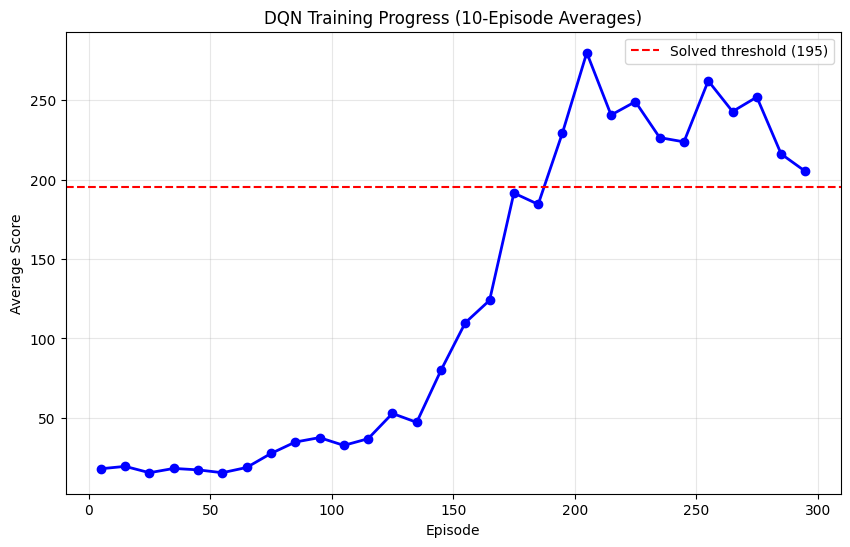

In [15]:
# Learning summary
import matplotlib.pyplot as plt

# Average scores every 10 episodes
episode_ranges = []
avg_scores = []

for i in range(0, len(training_scores), 10):
    episode_range = f"{i+1}-{min(i+10, len(training_scores))}"
    avg_score = np.mean(training_scores[i:i+10])  
    episode_ranges.append(i+5)  # Use middle of range for plotting
    avg_scores.append(avg_score)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(episode_ranges, avg_scores, 'b-o', linewidth=2, markersize=6)
plt.axhline(y=195, color='r', linestyle='--', label='Solved threshold (195)')
plt.xlabel('Episode')
plt.ylabel('Average Score')
plt.title('DQN Training Progress (10-Episode Averages)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()